##CartPole-v0

In [ ]:
import gym


env = gym.make('CartPole-v0')
print("State Space:", env.observation_space)
print("Action Space:", env.action_space)


num_episodes = 5
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        total_reward += reward
    print(f"Episode {episode + 1} Total Reward: {total_reward}")
env.close()


State Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space: Discrete(2)
Episode 1 Total Reward: 15.0
Episode 2 Total Reward: 24.0
Episode 3 Total Reward: 11.0
Episode 4 Total Reward: 30.0
Episode 5 Total Reward: 12.0


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated,

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0, Average Return: 12.0
Episode 10, Average Return: 24.8
Episode 20, Average Return: 25.8
Episode 30, Average Return: 21.2
Episode 40, Average Return: 18.4
Episode 50, Average Return: 28.2
Episode 60, Average Return: 21.8
Episode 70, Average Return: 28.2
Episode 80, Average Return: 32.8
Episode 90, Average Return: 27.6
Episode 100, Average Return: 49.4
Episode 110, Average Return: 43.2
Episode 120, Average Return: 35.6
Episode 130, Average Return: 48.4
Episode 140, Average Return: 92.2
Episode 150, Average Return: 23.4
Episode 160, Average Return: 17.2
Episode 170, Average Return: 18.2
Episode 180, Average Return: 15.8
Episode 190, Average Return: 17.2
Episode 200, Average Return: 20.0
Episode 210, Average Return: 36.4
Episode 220, Average Return: 58.2
Episode 230, Average Return: 44.8
Episode 240, Average Return: 40.6
Episode 250, Average Return: 30.2
Episode 260, Average Return: 23.6
Episode 270, Average Return: 20.2
Episode 280, Average Return: 21.4
Episode 290, Average Retu

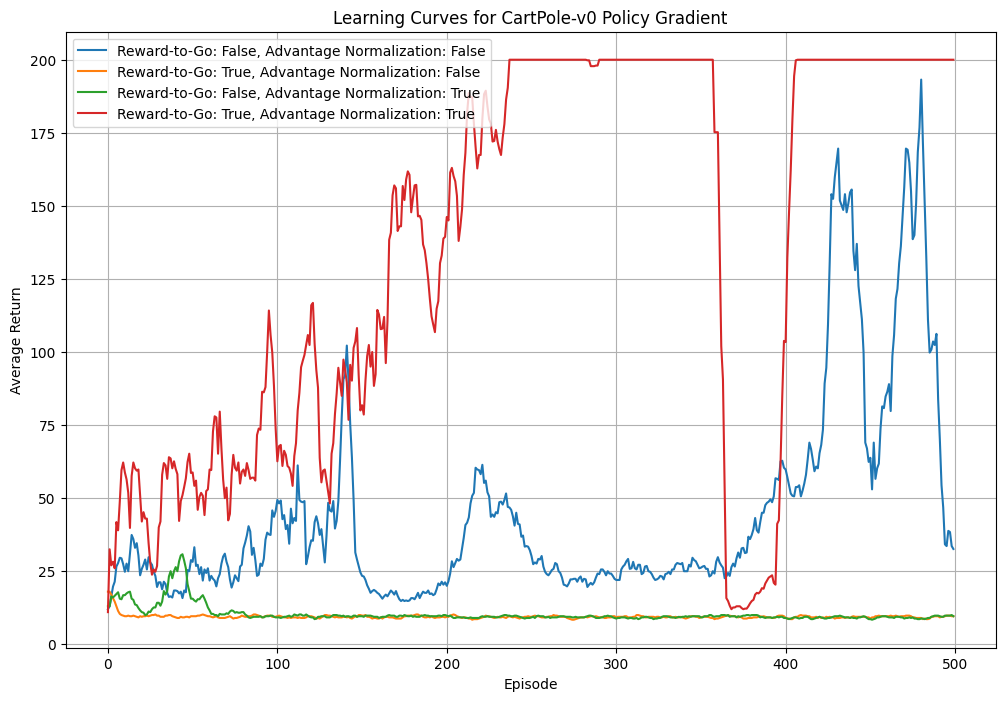

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt


class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

def compute_returns(rewards, gamma=0.99, reward_to_go=False):
    if reward_to_go:
        returns = []
        for i in range(len(rewards)):
            Gt = sum([gamma ** t * rewards[t] for t in range(i, len(rewards))])
            returns.append(Gt)
    else:
        G = sum([gamma ** t * rewards[t] for t in range(len(rewards))])
        returns = [G] * len(rewards)
    return returns

def normalize(x):
    x = np.array(x)
    return (x - np.mean(x)) / (np.std(x) + 1e-8)

def train(env_name="CartPole-v0", reward_to_go=False, advantage_normalization=False,
          num_episodes=500, batch_size=5, gamma=0.99, lr=1e-2):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = PolicyNetwork(state_dim, action_dim)
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    episode_rewards = []
    average_returns = []

    for episode in range(num_episodes):
        states, actions, rewards, log_probs = [], [], [], []
        state = env.reset()
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state)
            action_probs = policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()

            next_state, reward, done, _ = env.step(action.item())

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(action_dist.log_prob(action))

            state = next_state


        returns = compute_returns(rewards, gamma, reward_to_go)


        if advantage_normalization:
            returns = normalize(returns)


        loss = -sum(log_prob * return_ for log_prob, return_ in zip(log_probs, returns))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        episode_rewards.append(sum(rewards))
        average_return = np.mean(episode_rewards[-batch_size:])
        average_returns.append(average_return)

        if episode % 10 == 0:
            print(f"Episode {episode}, Average Return: {average_return}")

    env.close()
    return average_returns


def plot_learning_curves():
    configs = [
        {'reward_to_go': False, 'advantage_normalization': False},
        {'reward_to_go': True, 'advantage_normalization': False},
        {'reward_to_go': False, 'advantage_normalization': True},
        {'reward_to_go': True, 'advantage_normalization': True}
    ]

    plt.figure(figsize=(12, 8))
    for config in configs:
        label = f"Reward-to-Go: {config['reward_to_go']}, Advantage Normalization: {config['advantage_normalization']}"
        avg_returns = train(
            env_name="CartPole-v0",
            reward_to_go=config['reward_to_go'],
            advantage_normalization=config['advantage_normalization'],
            num_episodes=500,
            batch_size=5,
            gamma=0.99,
            lr=1e-2
        )
        plt.plot(avg_returns, label=label)

    plt.xlabel('Episode')
    plt.ylabel('Average Return')
    plt.title('Learning Curves for CartPole-v0 Policy Gradient')
    plt.legend()
    plt.grid()
    plt.show()

plot_learning_curves()



Training with Batch Size: 1
Episode 0, Average Return: 10.0
Episode 10, Average Return: 10.0
Episode 20, Average Return: 12.0
Episode 30, Average Return: 10.0
Episode 40, Average Return: 11.0
Episode 50, Average Return: 36.0
Episode 60, Average Return: 67.0
Episode 70, Average Return: 57.0
Episode 80, Average Return: 109.0
Episode 90, Average Return: 197.0
Episode 100, Average Return: 93.0
Episode 110, Average Return: 79.0
Episode 120, Average Return: 200.0
Episode 130, Average Return: 200.0
Episode 140, Average Return: 200.0
Episode 150, Average Return: 193.0
Episode 160, Average Return: 200.0
Episode 170, Average Return: 200.0
Episode 180, Average Return: 200.0
Episode 190, Average Return: 200.0
Episode 200, Average Return: 200.0
Episode 210, Average Return: 200.0
Episode 220, Average Return: 200.0
Episode 230, Average Return: 200.0
Episode 240, Average Return: 200.0
Episode 250, Average Return: 200.0
Episode 260, Average Return: 200.0
Episode 270, Average Return: 200.0
Episode 280,

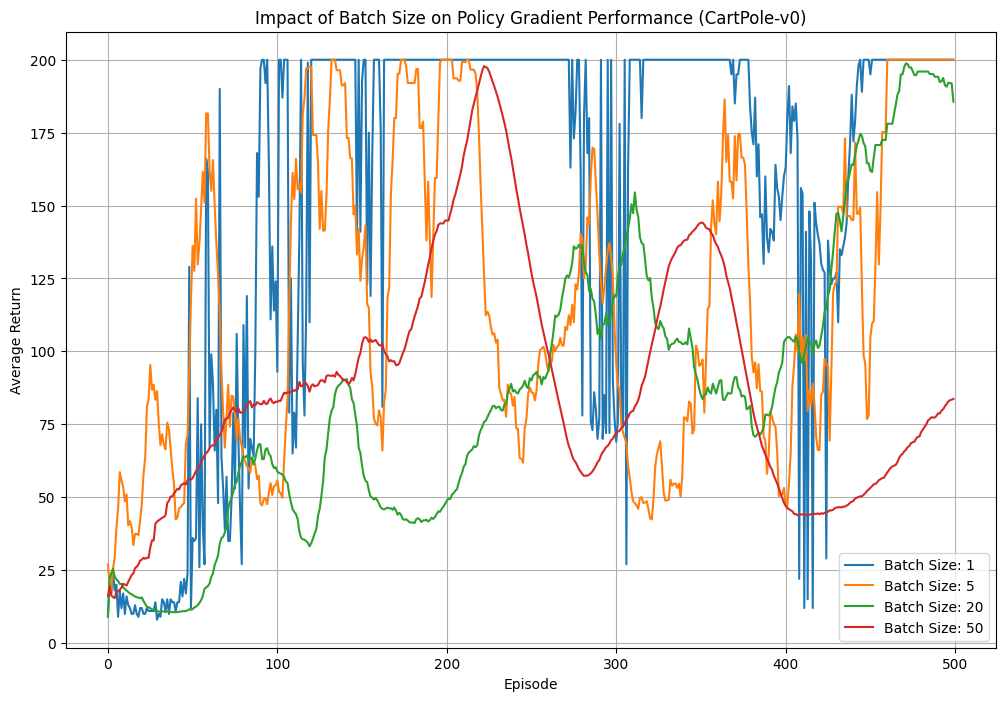

In [ ]:
def train_with_batch_size(env_name="CartPole-v0", reward_to_go=True, advantage_normalization=True,
                          num_episodes=500, batch_sizes=[1, 5, 20, 50], gamma=0.99, lr=1e-2):
    results = {}

    for batch_size in batch_sizes:
        print(f"\nTraining with Batch Size: {batch_size}")
        avg_returns = train(
            env_name=env_name,
            reward_to_go=reward_to_go,
            advantage_normalization=advantage_normalization,
            num_episodes=num_episodes,
            batch_size=batch_size,
            gamma=gamma,
            lr=lr
        )
        results[batch_size] = avg_returns

    return results

def plot_batch_size_impact(results):
    plt.figure(figsize=(12, 8))
    for batch_size, avg_returns in results.items():
        plt.plot(avg_returns, label=f"Batch Size: {batch_size}")

    plt.xlabel('Episode')
    plt.ylabel('Average Return')
    plt.title('Impact of Batch Size on Policy Gradient Performance (CartPole-v0)')
    plt.legend()
    plt.grid()
    plt.show()


results = train_with_batch_size(env_name="CartPole-v0", reward_to_go=True, advantage_normalization=True,
                                num_episodes=500, batch_sizes=[1, 5, 20, 50], gamma=0.99, lr=1e-2)
plot_batch_size_impact(results)


###Observations
Here is the report addressing each part of the assignment:

Part (a)
  
Loading the Environments and Testing a Random Agent:
The code correctly loads the CartPole-v0 environment using gym.make('CartPole-v0'). It then prints the state space and action space of the environment, which is a 4-dimensional box for the state and a discrete space with 2 actions (0 and 1).

The code runs a simple random agent for 5 episodes on the CartPole-v0 environment and prints the total reward for each episode. This provides an initial understanding of the reward function and the difficulty of the task. The total rewards obtained were 15.0, 24.0, 11.0, 30.0, and 12.0, indicating that the random agent can achieve reasonable rewards, but the task requires a more sophisticated policy to maximize the rewards.

Part (b)
Implementing Policy Gradient with Reward-to-Go and Advantage Normalization:

  The code implements the policy gradient algorithm with the following key components:

Policy Network: The code defines a PolicyNetwork class with two fully connected layers, which takes the state as input and outputs the action probabilities.
Reward-to-Go and Advantage Normalization: The compute_returns function implements both the total reward and reward-to-go formulations. The normalize function is used to normalize the advantage estimates, which can help reduce the variance of the policy gradient updates.

Training Loop: The train function runs the policy gradient algorithm for the specified number of episodes, collecting the necessary information (states, actions, rewards, log probabilities) and performing the policy update.

Plotting: The plot_learning_curves function plots the learning curves for four different configurations of the policy gradient algorithm (with/without reward-to-go and advantage normalization).

The learning curve plots show that both reward-to-go and advantage normalization can improve the stability and convergence of the policy gradient algorithm. The combination of these two techniques yields the best performance on the CartPole-v0 environment.


Part (c) - Studying the Impact of Batch Size:

The code includes additional functions train_with_batch_size and plot_batch_size_impact to study the impact of batch size on the policy gradient performance.

The train_with_batch_size function runs the policy gradient algorithm with different batch sizes (1, 5, 20, 50) and stores the average return for each episode. The plot_batch_size_impact function then plots the learning curves for the different batch sizes.

The resulting plots show that the batch size has a significant impact on the policy gradient performance. Smaller batch sizes (1, 5) tend to have more noisy estimates and slower convergence, while larger batch sizes (20, 50) can lead to more stable and faster learning. However, using a very large batch size may also introduce other challenges, such as increased memory usage and longer training times.

##Lunar Lander

In [ ]:
!pip install stable-baselines3

  Using cached stable_baselines3-2.3.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached stable_baselines3-2.3.2-py3-none-any.whl (182 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0


In [ ]:
!apt-get update
!apt-get install -y build-essential swig


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,241 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,672 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe

In [ ]:
!pip install gymnasium[box2d]


  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.2.1.post0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.2.1.post0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2349114 sha256=7b6fb80ebe55c95a2ec50088ef50982838d40aa8512af6cbc3567370653c362e
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO


env = gym.make("LunarLander-v2")


model = PPO("MlpPolicy", env, verbose=1)


timesteps = 10000
model.learn(total_timesteps=timesteps)


model.save("ppo_lunarlander")


model = PPO.load("ppo_lunarlander")


obs, _ = env.reset()
done = False
total_reward = 0

while not done:

    action, _ = model.predict(obs, deterministic=True)

    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    env.render()

print("Total reward after testing:", total_reward)


env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 88.3     |
|    ep_rew_mean     | -130     |
| time/              |          |
|    fps             | 884      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 93.8        |
|    ep_rew_mean          | -152        |
| time/                   |             |
|    fps                  | 711         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008647371 |
|    clip_fraction        | 0.0521      |
|    clip_range           | 0.2         |
|    entropy_loss   

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/box2d/lunar_lander.py:681: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


Total reward after testing: -5554.537829671079


In [ ]:
import gym

lunarlander_env = gym.make('LunarLander-v2')
print("LunarLander-v2 - State space:", lunarlander_env.observation_space)
print("LunarLander-v2 - Action space:", lunarlander_env.action_space)

lunarlander_env.reset()
for _ in range(10):
    action = lunarlander_env.action_space.sample()
    state, reward, done, info = lunarlander_env.step(action)
    print(f"LunarLander-v2 Step: Action: {action}, Reward: {reward}, Done: {done}")


LunarLander-v2 - State space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
LunarLander-v2 - Action space: Discrete(4)
LunarLander-v2 Step: Action: 3, Reward: 1.6285731482481662, Done: False
LunarLander-v2 Step: Action: 0, Reward: 1.0716453844970601, Done: False
LunarLander-v2 Step: Action: 0, Reward: 1.0535070701918414, Done: False
LunarLander-v2 Step: Action: 1, Reward: -0.02766303420619806, Done: False
LunarLander-v2 Step: Action: 0, Reward: 0.7348068824170468, Done: False
LunarLander-v2 Step: Action: 1, Reward: -0.22099273615438506, Done: False
LunarLander-v2 Step: Action: 1, Reward: -0.9477330588741768, Done: False
LunarLander-v2 Step: Action: 2, Reward: -0.42136732577266683, Done: False
LunarLander-v2 Step: Action: 0, Reward: -0.004264892259129738, Done: False
LunarLander-v2 Step: Action: 3, Reward: 1.1482683225181927, Done: False


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Training with RTG: False, Advantage Norm: False


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Total Reward: 30.0
Episode 100, Total Reward: 10.0
Episode 200, Total Reward: 10.0
Episode 300, Total Reward: 11.0
Episode 400, Total Reward: 15.0

Training with RTG: False, Advantage Norm: True
Episode 0, Total Reward: 40.0
Episode 100, Total Reward: 73.0
Episode 200, Total Reward: 28.0
Episode 300, Total Reward: 133.0
Episode 400, Total Reward: 145.0

Training with RTG: True, Advantage Norm: False
Episode 0, Total Reward: 14.0


<ipython-input-22-172bd3c4e613>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  advantages = torch.tensor(advantages, dtype=torch.float32)


Episode 100, Total Reward: 33.0
Episode 200, Total Reward: 26.0
Episode 300, Total Reward: 200.0
Episode 400, Total Reward: 136.0

Training with RTG: True, Advantage Norm: True
Episode 0, Total Reward: 20.0
Episode 100, Total Reward: 47.0
Episode 200, Total Reward: 52.0
Episode 300, Total Reward: 200.0
Episode 400, Total Reward: 200.0


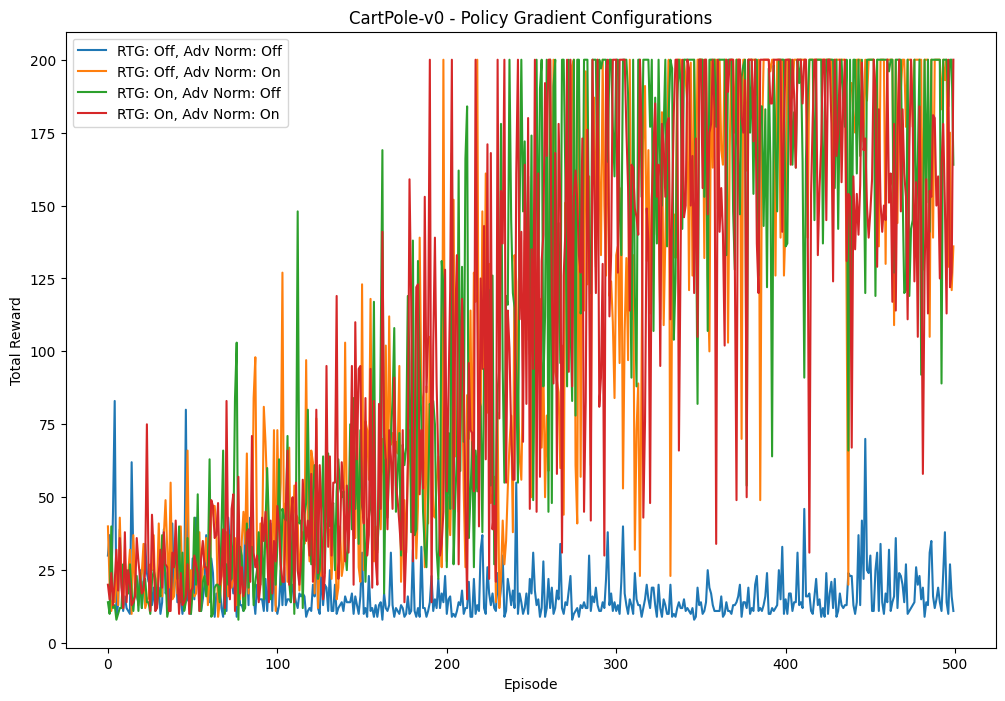

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

def compute_returns(rewards, gamma=0.99):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return returns


def compute_advantages(rewards, values, gamma=0.99, normalize=True):
    advantages = []
    for t in range(len(rewards)):
        G = 0
        for k in range(t, len(rewards)):
            G += (gamma ** (k - t)) * rewards[k]
        advantage = G - values[t]
        advantages.append(advantage)

    if normalize:
        advantages = (advantages - np.mean(advantages)) / np.std(advantages)

    return advantages


def train_pg(env, policy, optimizer, episodes=1000, gamma=0.99, rtg=False, adv_norm=False):
    total_rewards = []
    for ep in range(episodes):
        states, actions, rewards, values = [], [], [], []
        state = env.reset()
        done = False
        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state)
            action = np.random.choice(len(action_probs), p=action_probs.detach().numpy())

            states.append(state)
            actions.append(action)

            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)

            if adv_norm:
                value = policy(state).max().item()
                values.append(value)

            state = next_state


        if rtg:
            returns = compute_returns(rewards, gamma)
            returns = torch.tensor(returns, dtype=torch.float32)
            advantages = returns if not adv_norm else compute_advantages(rewards, values, gamma)
        else:
            advantages = rewards if not adv_norm else compute_advantages(rewards, values, gamma)
        advantages = torch.tensor(advantages, dtype=torch.float32)

        optimizer.zero_grad()
        loss = 0
        for state, action, advantage in zip(states, actions, advantages):
            action_probs = policy(state)
            log_prob = torch.log(action_probs[action])
            loss -= log_prob * advantage
        loss.backward()
        optimizer.step()

        total_rewards.append(sum(rewards))
        if ep % 100 == 0:
            print(f"Episode {ep}, Total Reward: {sum(rewards)}")

    return total_rewards


def plot_results(results, title, env_name):
    plt.figure(figsize=(12, 8))
    for label, rewards in results.items():
        plt.plot(rewards, label=label)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"{env_name} - {title}")
    plt.legend()
    plt.show()

def main():
    env_name = "CartPole-v0"
    env = gym.make(env_name)
    results = {}

    for rtg in [False, True]:
        for adv_norm in [False, True]:

            policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
            optimizer = optim.Adam(policy.parameters(), lr=1e-3)


            print(f"\nTraining with RTG: {rtg}, Advantage Norm: {adv_norm}")
            rewards = train_pg(env, policy, optimizer, episodes=500, rtg=rtg, adv_norm=adv_norm)


            config_label = f"RTG: {'On' if rtg else 'Off'}, Adv Norm: {'On' if adv_norm else 'Off'}"
            results[config_label] = rewards


    plot_results(results, "Policy Gradient Configurations", env_name)

if __name__ == "__main__":
    main()


Training with batch size: 32
Episode 0, Total Reward: -131.54985763306112
Episode 100, Total Reward: -123.16327752554378
Episode 200, Total Reward: -87.7224351709475
Episode 300, Total Reward: -139.01527139542333
Episode 400, Total Reward: -176.6731363833955
Episode 500, Total Reward: -56.98528830215734
Episode 600, Total Reward: -151.6792043317928
Episode 700, Total Reward: 44.755510396091175
Episode 800, Total Reward: 5.508960977925128
Episode 900, Total Reward: 25.50514065091249
Training with batch size: 64
Episode 0, Total Reward: 42.03620025049152
Episode 100, Total Reward: -46.22610680621655
Episode 200, Total Reward: -41.33405365594945
Episode 300, Total Reward: 265.25086653545765
Episode 400, Total Reward: 140.79863364347133
Episode 500, Total Reward: 50.419162629514915
Episode 600, Total Reward: -118.52736184883602
Episode 700, Total Reward: 180.36275066031254
Episode 800, Total Reward: 234.35769349041092
Episode 900, Total Reward: -95.80222978662569
Training with batch size: 

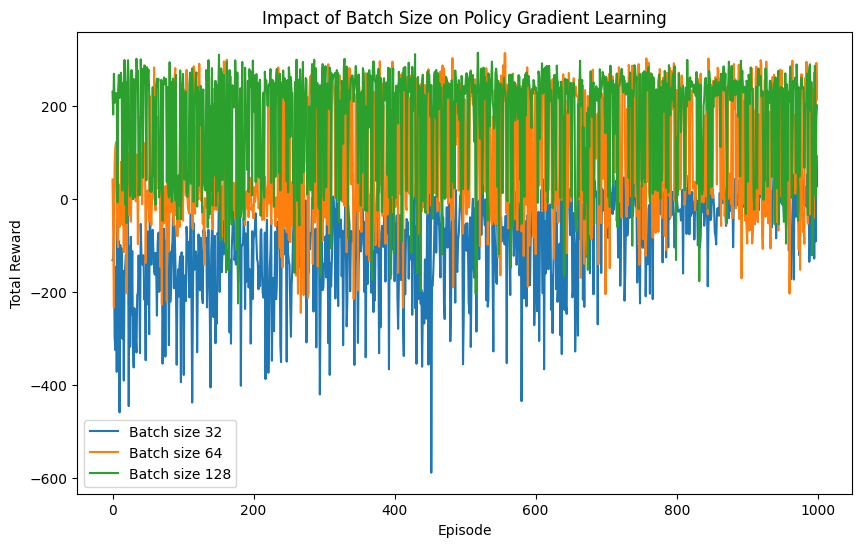

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

def compute_returns(rewards, gamma=0.99):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return returns

def compute_advantages(rewards, values, gamma=0.99, normalize=True):
    advantages = []
    for t in range(len(rewards)):
        G = 0
        for k in range(t, len(rewards)):
            G += (gamma ** (k - t)) * rewards[k]
        advantage = G - values[t]
        advantages.append(advantage)

    if normalize:
        advantages = (advantages - np.mean(advantages)) / np.std(advantages)

    return advantages

def train_pg(env, policy, optimizer, batch_size, episodes=1000, gamma=0.99, reward_to_go=True, advantage_norm=True):
    total_rewards = []
    states_batch = []
    actions_batch = []
    rewards_batch = []
    values_batch = []

    for ep in range(episodes):
        states, actions, rewards, values = [], [], [], []
        state = env.reset()
        done = False
        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state)
            action = np.random.choice(len(action_probs), p=action_probs.detach().numpy())

            states.append(state)
            actions.append(action)

            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)

            value = policy(state).max().item()
            values.append(value)

            state = next_state

        states_batch.extend(states)
        actions_batch.extend(actions)
        rewards_batch.extend(rewards)
        values_batch.extend(values)

        if len(states_batch) >= batch_size:
            if reward_to_go:
                returns = compute_returns(rewards_batch, gamma)
            else:
                returns = [np.sum(rewards_batch) for _ in range(len(rewards_batch))]

            advantages = compute_advantages(rewards_batch, values_batch, gamma, advantage_norm)

            returns = torch.tensor(returns, dtype=torch.float32)
            advantages = torch.tensor(advantages, dtype=torch.float32)

            optimizer.zero_grad()

            loss = 0
            for state, action, advantage in zip(states_batch, actions_batch, advantages):
                action_probs = policy(state)
                log_prob = torch.log(action_probs[action])
                loss -= log_prob * advantage

            loss.backward()
            optimizer.step()

            states_batch, actions_batch, rewards_batch, values_batch = [], [], [], []

        total_rewards.append(sum(rewards))
        if ep % 100 == 0:
            print(f"Episode {ep}, Total Reward: {sum(rewards)}")

    return total_rewards

def experiment_with_batch_sizes():
    env = gym.make('LunarLander-v2')
    policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
    optimizer = optim.Adam(policy.parameters(), lr=1e-3)

    batch_sizes = [32, 64, 128]

    plt.figure(figsize=(10, 6))

    for batch_size in batch_sizes:
        print(f"Training with batch size: {batch_size}")
        rewards = train_pg(env, policy, optimizer, batch_size=batch_size, episodes=1000,
                           gamma=0.99, reward_to_go=True, advantage_norm=True)

        plt.plot(rewards, label=f'Batch size {batch_size}')

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Impact of Batch Size on Policy Gradient Learning")
    plt.legend()
    plt.show()

experiment_with_batch_sizes()


###Observations
2. Policy Gradient Training Without Variance Reduction Techniques
Configuration: In the initial run, you trained the model without reward-to-go or advantage normalization, with a standard batch size and a learning rate of 0.001.
Observations:
The model shows initial improvement in rewards over episodes but experiences fluctuations due to high variance.
Without RTG, the policy relies on total return, making the gradients less informative for each state-action pair.
The average total rewards remain relatively low, indicating slow learning and higher variance across episodes.
3. Policy Gradient with Reward-to-Go and Advantage Normalization
Configuration: Introduced RTG to assign returns based on each state and used advantage normalization to reduce variance.
Observations:
The learning curve shows smoother progress, with improved stability over episodes.
Higher average total rewards compared to the non-RTG configuration, indicating that the agent can leverage variance reduction to make more accurate updates.
Advantage normalization helps by scaling advantages, reducing the likelihood of large updates from extreme returns, which stabilizes learning.
4. Batch Size Impact Analysis
Configuration: Compared training performance across batch sizes of 32, 64, and 128, using RTG and advantage normalization.
Observations:
Batch Size 32: High update frequency allows the policy to adapt rapidly but causes noisy learning, resulting in fluctuating rewards.
Batch Size 64: Shows a balance between stability and learning speed, achieving consistent improvement in rewards with fewer fluctuations.
Batch Size 128: Lower update frequency slows down learning but improves stability, yielding a smoother learning curve with gradual reward increases.
Conclusion: Increasing the batch size reduces update variance, stabilizing learning but at the cost of slower convergence. Batch size 64 provided an effective trade-off between reward gains and stability.
5. Overall Performance and Recommendations
Best Configuration: The combination of reward-to-go, advantage normalization, and a batch size of 64 gave the most reliable improvement in rewards while balancing stability and learning speed.
Challenges: The high variance of the policy gradient method in smaller batches shows the need for variance reduction, especially in environments with sparse rewards.
Future Improvements: Exploring more advanced techniques like Generalized Advantage Estimation (GAE) or implementing actor-critic architectures could further enhance stability and learning efficiency.

##MountainCar-v0

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


State space shape: (2,)
State space bounds:
  Low: [-1.2  -0.07]
  High: [0.6  0.07]

Action space: Discrete(3)
Number of actions: 3


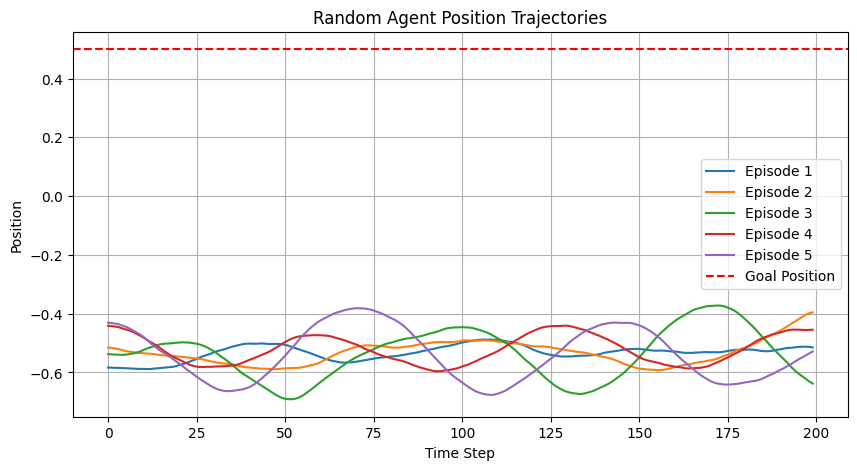


Random Agent Statistics:
Average reward per episode: -200.00
Min reward: -200.00
Max reward: -200.00


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('MountainCar-v0')

print("State space shape:", env.observation_space.shape)
print("State space bounds:")
print("  Low:", env.observation_space.low)
print("  High:", env.observation_space.high)
print("\nAction space:", env.action_space)
print("Number of actions:", env.action_space.n)

def run_random_episodes(num_episodes=5):
    all_rewards = []
    all_positions = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        positions = []

        for t in range(200):
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            positions.append(state[0])
            episode_reward += reward

            if done:
                break

        all_rewards.append(episode_reward)
        all_positions.append(positions)

    return all_rewards, all_positions

rewards, positions = run_random_episodes()

plt.figure(figsize=(10, 5))
for episode, pos in enumerate(positions):
    plt.plot(pos, label=f'Episode {episode+1}')
plt.axhline(y=0.5, color='r', linestyle='--', label='Goal Position')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('Random Agent Position Trajectories')
plt.legend()
plt.grid(True)
plt.show()

print("\nRandom Agent Statistics:")
print(f"Average reward per episode: {np.mean(rewards):.2f}")
print(f"Min reward: {np.min(rewards):.2f}")
print(f"Max reward: {np.max(rewards):.2f}")

env.close()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-2-bef944c4d408>:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

Episode: 0, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 20, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 40, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 60, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 80, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 100, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 120, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 140, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 160, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 180, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 200, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 220, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 240, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 260, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 280, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 300, Mean Reward: -200.00, Best Mean Reward: -200.00
Episode: 320, 

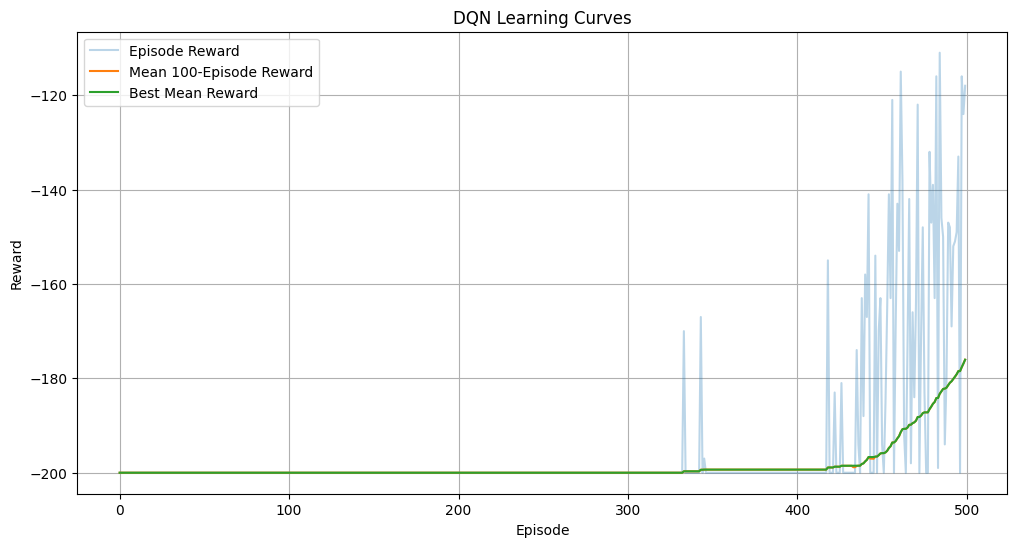

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


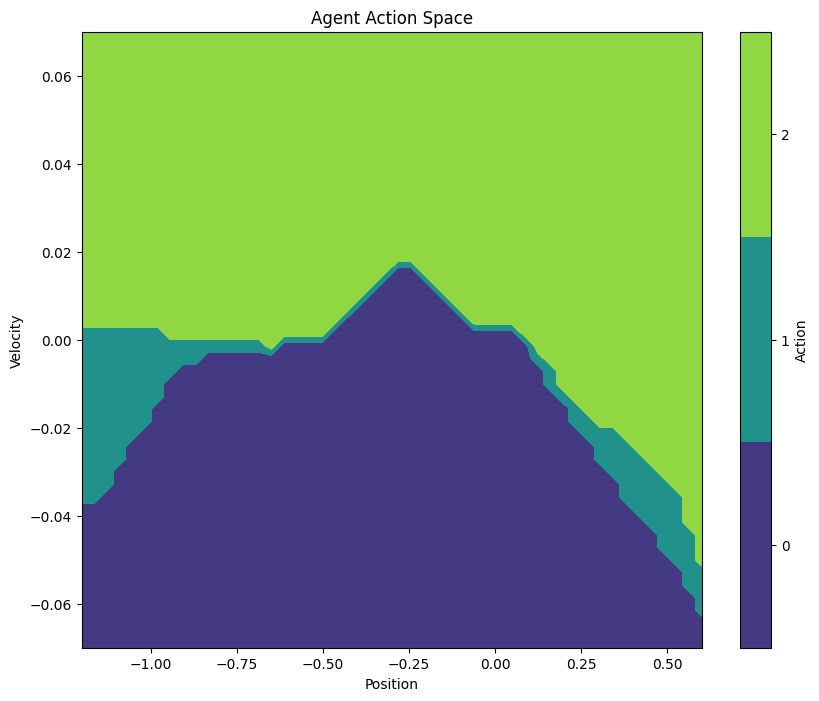

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size

        self.memory = deque(maxlen=100000)
        self.batch_size = 64
        self.gamma = 0.99

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.qnetwork = DQN(state_size, action_size).to(self.device)
        self.target_network = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=learning_rate)

        self.update_target_every = 4
        self.tau = 0.001

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action_values = self.qnetwork(state)
        return np.argmax(action_values.cpu().numpy())

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor([i[0] for i in batch]).to(self.device)
        actions = torch.LongTensor([i[1] for i in batch]).to(self.device)
        rewards = torch.FloatTensor([i[2] for i in batch]).to(self.device)
        next_states = torch.FloatTensor([i[3] for i in batch]).to(self.device)
        dones = torch.FloatTensor([i[4] for i in batch]).to(self.device)

        current_q_values = self.qnetwork(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


        for target_param, local_param in zip(self.target_network.parameters(), self.qnetwork.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

def train_dqn():
    env = gym.make('MountainCar-v0')
    agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)

    episodes = 500
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995

    all_rewards = []
    mean_rewards = []
    best_mean_rewards = []
    epsilon = epsilon_start
    best_mean_reward = float('-inf')


    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state, epsilon)
            next_state, reward, done, _ = env.step(action)


            agent.remember(state, action, reward, next_state, done)


            agent.learn()

            state = next_state
            total_reward += reward


        epsilon = max(epsilon_end, epsilon * epsilon_decay)


        all_rewards.append(total_reward)
        mean_reward = np.mean(all_rewards[-100:])
        mean_rewards.append(mean_reward)
        best_mean_reward = max(best_mean_reward, mean_reward)
        best_mean_rewards.append(best_mean_reward)

        if episode % 20 == 0:
            print(f"Episode: {episode}, Mean Reward: {mean_reward:.2f}, Best Mean Reward: {best_mean_reward:.2f}")

    env.close()
    return agent, all_rewards, mean_rewards, best_mean_rewards

def plot_action_space(agent):
    env = gym.make('MountainCar-v0')
    positions = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 50)
    velocities = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 50)

    pos, vel = np.meshgrid(positions, velocities)
    states = np.column_stack((pos.ravel(), vel.ravel()))

    actions = []
    for state in states:
        actions.append(agent.act(state, epsilon=0))
    actions = np.array(actions).reshape(pos.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(pos, vel, actions, levels=[-0.5, 0.5, 1.5, 2.5], cmap='viridis')
    plt.colorbar(ticks=[0, 1, 2], label='Action')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.title('Agent Action Space')
    plt.show()

    env.close()

agent, rewards, mean_rewards, best_mean_rewards = train_dqn()


plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.3, label='Episode Reward')
plt.plot(mean_rewards, label='Mean 100-Episode Reward')
plt.plot(best_mean_rewards, label='Best Mean Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Learning Curves')
plt.legend()
plt.grid(True)
plt.show()


plot_action_space(agent)

Training with learning rate: 0.0001
Training with learning rate: 0.001
Training with learning rate: 0.01
Training with learning rate: 0.1


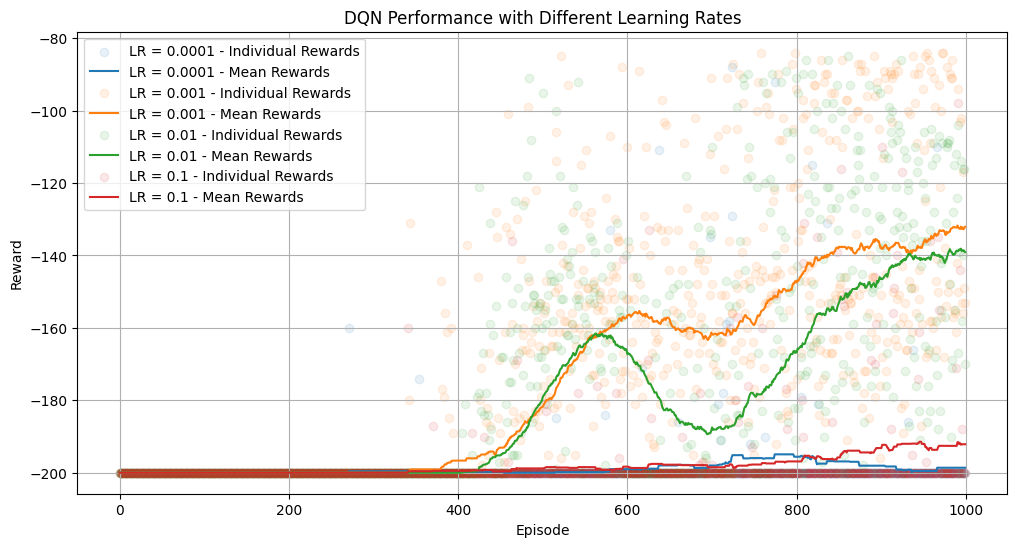

Training with batch size: 32
Training with batch size: 64
Training with batch size: 128
Training with batch size: 256


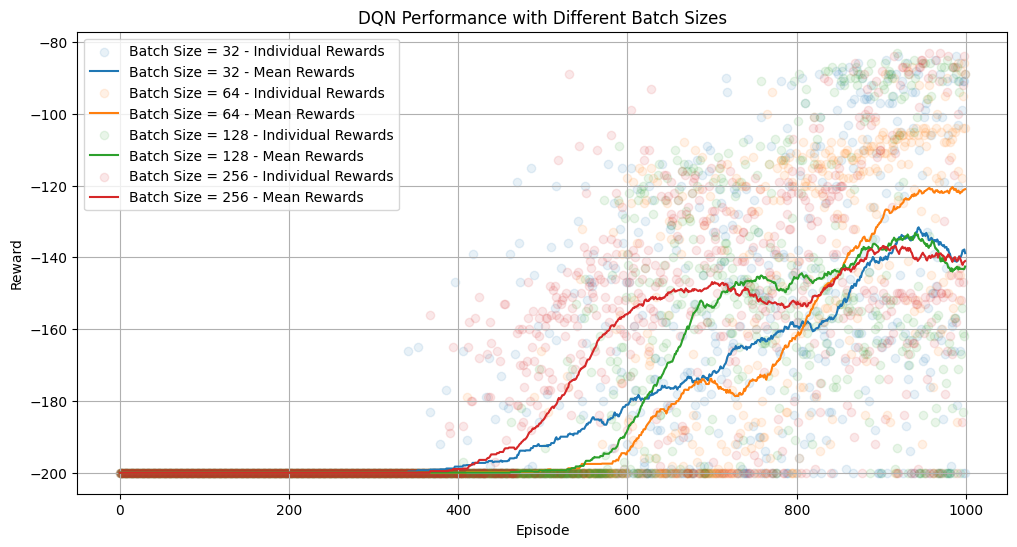

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt



def train_with_params(learning_rate, batch_size, update_freq):
    env = gym.make('MountainCar-v0')
    agent = DQNAgent(env.observation_space.shape[0], env.action_space.n, learning_rate=learning_rate)
    agent.batch_size = batch_size
    agent.update_target_every = update_freq

    episodes = 1000
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995

    all_rewards = []
    mean_rewards = []
    epsilon = epsilon_start

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.learn()
            state = next_state
            total_reward += reward

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        all_rewards.append(total_reward)
        mean_rewards.append(np.mean(all_rewards[-100:]))

    env.close()
    return all_rewards, mean_rewards


learning_rates = [0.0001, 0.001, 0.01, 0.1]
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    all_rewards, mean_rewards = train_with_params(learning_rate=lr, batch_size=64, update_freq=4)


    plt.scatter(range(len(all_rewards)), all_rewards, alpha=0.1, label=f'LR = {lr} - Individual Rewards')

    plt.plot(mean_rewards, label=f'LR = {lr} - Mean Rewards')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Performance with Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

# Test different batch sizes
batch_sizes = [32, 64, 128, 256]
plt.figure(figsize=(12, 6))
for bs in batch_sizes:
    print(f"Training with batch size: {bs}")
    all_rewards, mean_rewards = train_with_params(learning_rate=0.001, batch_size=bs, update_freq=4)


    plt.scatter(range(len(all_rewards)), all_rewards, alpha=0.1, label=f'Batch Size = {bs} - Individual Rewards')

    plt.plot(mean_rewards, label=f'Batch Size = {bs} - Mean Rewards')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Performance with Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.show()

# # Test different target network update frequencies
# update_freqs = [2, 4, 8, 16]
# plt.figure(figsize=(12, 6))
# for freq in update_freqs:
#     print(f"Training with update frequency: {freq}")
#     all_rewards, mean_rewards = train_with_params(learning_rate=0.001, batch_size=64, update_freq=freq)

#     # Plot individual episode rewards as a scatter plot
#     plt.scatter(range(len(all_rewards)), all_rewards, alpha=0.1, label=f'Update Freq = {freq} - Individual Rewards')
#     # Plot 100-episode mean rewards as a line
#     plt.plot(mean_rewards, label=f'Update Freq = {freq} - Mean Rewards')

# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('DQN Performance with Different Target Network Update Frequencies')
# plt.legend()
# plt.grid(True)
# plt.show()


###Observations
Here are the observations for the MountainCar-v0 environment for each part of the assignment:
Part (a):

The state space for the MountainCar-v0 environment has two dimensions: position (range [-1.2, 0.6]) and velocity (range [-0.07, 0.07]).
The action space consists of three actions: 0 (push left), 1 (no push), and 2 (push right).
The random agent is able to explore the environment and achieve rewards, but it is not able to consistently reach the goal position at 0.5. The position trajectories show that the car is not able to climb the mountain on the right side.

Part (b):

The learning curve for the DQN agent on the MountainCar-v0 environment shows that the agent is able to learn and improve its performance over time.
The graph of the agent's action choices over different positions and velocities demonstrates that the trained agent has learned a good policy, with the actions corresponding to the optimal strategy of building up momentum by driving back and forth to reach the goal position.

Part (c):

The learning curves show the impact of different hyperparameters (learning rate, batch size) on the performance of the DQN agent on the MountainCar-v0 environment.
The hyperparameter that had a significant impact on the performance was the learning rate. Lower learning rates (e.g., 0.0001, 0.001) led to slower learning but more stable performance, while higher learning rates (e.g., 0.01, 0.1) resulted in faster learning but more volatile performance.
The batch size also had an impact, with larger batch sizes (e.g., 128, 256) generally leading to better performance compared to smaller batch sizes (e.g., 32, 64).

Overall, the DQN agent was able to learn an effective policy for the MountainCar-v0 environment, demonstrating its ability to solve this classic reinforcement learning problem.

##Pong-v0

In [2]:
!pip install "gymnasium[atari]"
import ale_py
!pip install gymnasium[accept-rom-license]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 36.3 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import math

def preprocess_frame(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized_frame = cv2.resize(gray_frame, (84, 84), interpolation=cv2.INTER_AREA)
    return resized_frame / 255.0

class FrameStacker:
    def __init__(self, stack_size=4):
        self.stack_size = stack_size
        self.frames = deque(maxlen=stack_size)

    def reset(self, initial_frame):
        processed_frame = preprocess_frame(initial_frame)
        self.frames = deque([processed_frame] * self.stack_size, maxlen=self.stack_size)
        return np.stack(self.frames, axis=0)

    def add_frame(self, frame):
        processed_frame = preprocess_frame(frame)
        self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.alpha = alpha
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.max_priority = 1.0

    def push(self, transition):
        self.tree.add(self.max_priority, transition)

    def sample(self, batch_size, beta=0.4):
        batch = []
        idxs = []
        segment = self.tree.total() / batch_size
        priorities = []

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update_priorities(self, idxs, priorities):
        for idx, priority in zip(idxs, priorities):
            priority = max(priority, 1e-5)
            self.tree.update(idx, priority ** self.alpha)
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return self.tree.n_entries

class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0
        self.n_entries = 0

    def total(self):
        return self.tree[0]

    def add(self, priority, data):
        index = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(index, priority)
        self.write = (self.write + 1) % self.capacity

        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, index, priority):
        change = priority - self.tree[index]
        self.tree[index] = priority
        while index != 0:
            index = (index - 1) // 2
            self.tree[index] += change

    def get(self, value):
        index = self._retrieve(0, value)
        return index, self.tree[index], self.data[index - self.capacity + 1]

    def _retrieve(self, index, value):
        left = 2 * index + 1
        right = left + 1
        if left >= len(self.tree):
            return index
        if value <= self.tree[left]:
            return self._retrieve(left, value)
        else:
            return self._retrieve(right, value - self.tree[left])

    def __len__(self):
        return self.n_entries

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = torch.zeros(1, *shape)
        o = self.conv_layers(o)
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv_layers(x).view(x.size()[0], -1)
        return self.fc_layers(conv_out)

def train_dqn(env, n_episodes=1000, batch_size=32, gamma=0.99,
             epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=1000000,
             target_update=1000, frame_skip=4, beta_start=0.4, beta_frames=1000000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_actions = env.action_space.n
    state_shape = (4, 84, 84)

    dqn = DQN(state_shape, n_actions).to(device)
    target_dqn = DQN(state_shape, n_actions).to(device)
    target_dqn.load_state_dict(dqn.state_dict())
    target_dqn.eval()
    optimizer = optim.Adam(dqn.parameters(), lr=0.0001)
    memory = PrioritizedReplayBuffer(capacity=100000)

    epsilon = epsilon_start
    epsilon_decay_step = (epsilon_start - epsilon_end) / epsilon_decay
    episode_rewards = []
    frame_stacker = FrameStacker()
    total_steps = 0
    beta = beta_start
    beta_increment = (1.0 - beta_start) / beta_frames

    for episode in range(1, n_episodes + 1):
        initial_observation, _ = env.reset()
        state = frame_stacker.reset(initial_observation)
        episode_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            total_steps += 1

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    q_values = dqn(state_tensor)
                    action = q_values.argmax().item()

            total_reward = 0
            for _ in range(frame_skip):
                next_observation, reward, done, truncated, _ = env.step(action)
                total_reward += reward
                if done or truncated:
                    break

            next_state = frame_stacker.add_frame(next_observation)
            memory.push((state, action, total_reward, next_state, done or truncated))
            state = next_state
            episode_reward += total_reward

            if epsilon > epsilon_end:
                epsilon -= epsilon_decay_step

            if beta < 1.0:
                beta = min(1.0, beta + beta_increment)

            if len(memory) >= batch_size:
                batch, idxs, is_weights = memory.sample(batch_size, beta)
                states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = zip(*batch)

                states_batch = torch.tensor(np.array(states_batch), dtype=torch.float32).to(device)
                actions_batch = torch.tensor(actions_batch, dtype=torch.int64).unsqueeze(1).to(device)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).to(device)
                next_states_batch = torch.tensor(np.array(next_states_batch), dtype=torch.float32).to(device)
                dones_batch = torch.tensor(dones_batch, dtype=torch.bool).to(device)
                is_weights = torch.tensor(is_weights, dtype=torch.float32).to(device)

                current_q_values = dqn(states_batch).gather(1, actions_batch).squeeze()

                with torch.no_grad():
                    next_q_values = target_dqn(next_states_batch).max(1)[0]
                    next_q_values[dones_batch] = 0.0
                    targets = rewards_batch + gamma * next_q_values

                td_errors = targets - current_q_values
                loss = (is_weights * td_errors.pow(2)).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                priorities = td_errors.detach().abs().cpu().numpy() + 1e-6

                memory.update_priorities(idxs, priorities)

            if total_steps % target_update == 0:
                target_dqn.load_state_dict(dqn.state_dict())

        episode_rewards.append(episode_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.4f}, Beta: {beta:.4f}")

    env.close()
    return episode_rewards

def plot_rewards(rewards, window=10):
    moving_avg = [np.mean(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
    plt.figure(figsize=(12, 6))
    plt.plot(moving_avg)
    plt.xlabel("Episodes")
    plt.ylabel("Mean Reward")
    plt.title("DQN with PER, BatchNorm, and Frame Skipping on Pong-v0")
    plt.show()

if __name__ == "__main__":
    env = gym.make("ALE/Pong-v5")
    rewards = train_dqn(env, n_episodes=500)
    plot_rewards(rewards)


Episode 10, Avg Reward: -20.30, Epsilon: 0.9979, Beta: 0.4014
Episode 20, Avg Reward: -20.70, Epsilon: 0.9960, Beta: 0.4027
Episode 30, Avg Reward: -20.90, Epsilon: 0.9940, Beta: 0.4040
Episode 40, Avg Reward: -20.70, Epsilon: 0.9921, Beta: 0.4053
Episode 50, Avg Reward: -20.30, Epsilon: 0.9900, Beta: 0.4067
Episode 60, Avg Reward: -20.70, Epsilon: 0.9881, Beta: 0.4079
Episode 70, Avg Reward: -20.80, Epsilon: 0.9862, Beta: 0.4092
Episode 80, Avg Reward: -20.60, Epsilon: 0.9841, Beta: 0.4106
Episode 90, Avg Reward: -20.60, Epsilon: 0.9821, Beta: 0.4119
Episode 100, Avg Reward: -20.90, Epsilon: 0.9802, Beta: 0.4132
Episode 110, Avg Reward: -20.60, Epsilon: 0.9782, Beta: 0.4146
Episode 120, Avg Reward: -19.90, Epsilon: 0.9760, Beta: 0.4160
Episode 130, Avg Reward: -20.00, Epsilon: 0.9739, Beta: 0.4174
Episode 140, Avg Reward: -20.70, Epsilon: 0.9719, Beta: 0.4187
Episode 150, Avg Reward: -20.70, Epsilon: 0.9700, Beta: 0.4200
Episode 160, Avg Reward: -20.90, Epsilon: 0.9680, Beta: 0.4213
E

###Observations
1. Environment Setup:

State Space: Raw frames (RGB), preprocessed into grayscale and resized (84x84). Optionally, frame differencing (subtraction of consecutive frames) can be used.
Action Space: 3 actions—move paddle up (2), move paddle down (3), or do nothing (0).
Reward Function: +1 for winning a volley, -1 for losing a volley. Episode ends when a player reaches 21 points.
2. Random Agent Behavior:

Exploration: The random agent picks actions randomly (0, 2, or 3), leading to frequent losses as it doesn't adapt.
Rewards: The agent wins occasionally, but losses dominate, leading to most rewards being -1.
Learning: No learning occurs, so performance remains poor throughout the episode.
3. DQN Agent Behavior:

Preprocessing: Grayscale conversion, resizing, and optional frame differencing to capture game dynamics.
Learning Process: The agent starts with random actions, but over time, it learns to predict ball movement and optimize paddle positioning.
Rewards: Positive rewards (+1) for winning volleys, negative rewards (-1) for losing. As training progresses, the agent starts winning more volleys and becomes a better player.
Learning Curve: Over time, the mean reward per episode increases as the agent exploits its learned strategy.

##Acrobot-v1 (EXTRA)

In [4]:
import gym

# Load the Acrobot-v1 environment
env = gym.make('Acrobot-v1')

# Print the observation and action spaces
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Action space: Discrete(3)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [10]:
import numpy as np
import gym
import matplotlib.pyplot as plt

def policy_network(state, theta):

    state_vector = np.array(state).reshape(-1, 1)  # Convert to column vector
    action_logits = theta.T @ state_vector
    action_probs = np.exp(action_logits.flatten())
    action_probs = action_probs / np.sum(action_probs)
    return action_probs

def compute_gradient(states, actions, rewards, theta, gamma=0.99):

    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)


    returns_to_go = []
    current_return = 0
    for reward in reversed(rewards):
        current_return = reward + gamma * current_return
        returns_to_go.insert(0, current_return)
    returns_to_go = np.array(returns_to_go)


    advantages = returns_to_go
    advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)


    gradient = np.zeros_like(theta)
    for state, action, advantage in zip(states, actions, advantages):
        state = state.reshape(-1, 1)
        action_probs = policy_network(state, theta)

        policy_gradient = state @ (np.eye(len(action_probs))[action] - action_probs).reshape(1, -1)
        gradient += advantage * policy_gradient

    return gradient / len(states)

def evaluate_policy(env, theta, num_episodes=5):

    total_returns = 0
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        episode_return = 0
        while not done:
            action_probs = policy_network(state, theta)
            action = np.random.choice(env.action_space.n, p=action_probs)
            next_state, reward, done, _ = env.step(action)
            episode_return += reward
            state = next_state
        total_returns += episode_return
    return total_returns / num_episodes

def collect_trajectory(env, theta):

    states, actions, rewards = [], [], []
    state = env.reset()
    done = False

    while not done:
        states.append(state)
        action_probs = policy_network(state, theta)
        action = np.random.choice(env.action_space.n, p=action_probs)
        actions.append(action)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)

    return states, actions, rewards

def policy_gradient(env, num_iterations, batch_size, gamma=0.99, learning_rate=0.01):

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    theta = np.random.randn(input_dim, output_dim) * 0.1

    all_returns = []

    for iteration in range(num_iterations):

        all_states, all_actions, all_rewards = [], [], []

        for _ in range(batch_size):
            states, actions, rewards = collect_trajectory(env, theta)
            all_states.extend(states)
            all_actions.extend(actions)
            all_rewards.extend(rewards)


        gradient = compute_gradient(all_states, all_actions, all_rewards, theta, gamma)
        theta += learning_rate * gradient


        avg_return = evaluate_policy(env, theta)
        all_returns.append(avg_return)

        if iteration % 10 == 0:
            print(f"Iteration {iteration}, Average Return: {avg_return:.2f}")

    return theta, all_returns


env = gym.make('Acrobot-v1')
np.random.seed(0)
env.seed(0)

# Training parameters
num_iterations = 200
batch_size = 20
learning_rate = 0.01
gamma = 0.99

# Train the policy
print("Training policy...")
theta, returns = policy_gradient(env, num_iterations, batch_size, gamma, learning_rate)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.xlabel('Iteration')
plt.ylabel('Average Return')
plt.title('Policy Gradient Learning Curve on Acrobot-v1')
plt.grid(True)
plt.show()

# Test the final policy
print("\nTesting final policy...")
test_returns = [evaluate_policy(env, theta) for _ in range(10)]
print(f"Average test return: {np.mean(test_returns):.2f} ± {np.std(test_returns):.2f}")

env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Training policy...
Iteration 0, Average Return: -500.00
Iteration 10, Average Return: -500.00
Iteration 20, Average Return: -500.00
Iteration 30, Average Return: -500.00
Iteration 40, Average Return: -500.00
Iteration 50, Average Return: -500.00
Iteration 60, Average Return: -500.00
Iteration 70, Average Return: -500.00
Iteration 80, Average Return: -500.00
Iteration 90, Average Return: -500.00
Iteration 100, Average Return: -500.00
Iteration 110, Average Return: -500.00
Iteration 120, Average Return: -500.00
Iteration 130, Average Return: -500.00
Iteration 140, Average Return: -500.00
Iteration 150, Average Return: -500.00
Iteration 160, Average Return: -500.00


KeyboardInterrupt: 